In [1]:
from matplotlib import pyplot as plt
import numpy as np

from sigproc_kit import *

from my_utils import *

In [2]:
def ana_rot(I,Q,itime,**kwargs):


    phi = np.arctan2(Q,I)
    
    rotations   = np.array([])
    gap_centers = np.array([])


    plot = kwargs.get("plot",False)
    
    last_gap_center = 0
    rotation = 0
    
    my_range = int(np.max(itime))+1
    
    last_start_of_block = -1000
    last_end_of_block   = -1000
    last_block_center   = -1000
    last_block_over_gap      = False
    

    for i in range(my_range):
        mask = (itime == i)
        phiset=phi[mask]
        
        
        if(plot):
            print("i = {}".format(i))
            plt.hist(phiset,bins=np.arange(-3.2,3.2,.1))
            plt.show()
            
        gap_center = 0
            
        if len(phiset) > 0:
        
            phiset.sort()
            
            rot_phiset = np.concatenate((phiset[1:],phiset[:1])) 
            
            distance = (rot_phiset - phiset) % (2*np.pi)
            
            end_of_block = phiset[np.argmax(distance)]
            start_of_block = phiset[ (np.argmax(distance)+1) % len(phiset) ]
            max_distance  = np.max(distance)
            block_width   = 2*np.pi - max_distance
            gap_center = ((end_of_block + max_distance/2 + np.pi) % (2*np.pi)) - np.pi
            block_center = ((start_of_block + block_width/2 + np.pi) % (2*np.pi)) - np.pi
            #plt.plot(distance)
            #plt.show()
            if(0):
                print("gap distance: {}".format(max_distance))
                print("start of block: {}".format(start_of_block))
                print("end of block: {}".format(end_of_block))
                print("gap center: {}".format(gap_center))
                print("block center: {}".format(block_center))
            
            block_over_gap = block_center > gap_center
            
            #if (last_block_over_gap == False) and (block_over_gap == True):
                #rotation += 1
            if gap_center < last_gap_center:
                rotation += 1
                
            #print("counted rotations: {}".format(rotation))
            
            last_gap_center     = gap_center
            last_start_of_block = start_of_block
            last_end_of_block   = end_of_block
            last_block_center   = block_center
            last_block_over_gap = block_over_gap
            
        gap_centers = np.append(gap_centers,[gap_center])
        rotations   = np.append(rotations,[rotation])
        
    #print(gap_centers)
   
    if(True):
        idx = list(range(my_range))
        plt.plot(idx,rotations)
        plt.scatter(idx,rotations,label="rotations")
        plt.plot(idx,gap_centers)
        plt.scatter(idx,gap_centers,label="gap centers")
        plt.title("unfolding analysis")
        plt.legend()
        plt.xlabel("intermediate time")
        plt.show()
        
    return (rotations,gap_centers)

def cont_phi_new(I,Q,itime,rotations,gap_centers):
    
    phi = np.arctan2(Q,I)
    
    new_phi = np.zeros(len(phi))
    
    for i, phival in enumerate(phi):
        
        index = int(itime[i]) 
        if phival >= gap_centers[index]: # the lower valued part
                new_phi[i] = phival  + (rotations[index])*2*np.pi
        else: # higher valued part
                new_phi[i] = phival  + (rotations[index]+1)*2*np.pi
        
        
        
    return new_phi + np.pi

In [16]:
t = np.arange(0.,4e-9,2.5e-12)

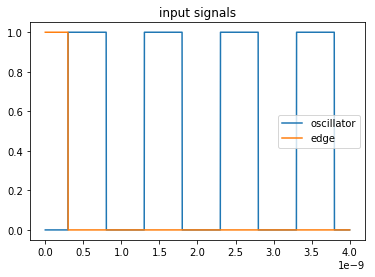

In [18]:
osc_freq=1000e6

hit_time = 300e-12 

edge = t < hit_time

#osc  = sqwave(2*np.pi*(t-hit_time)*osc_freq)>0

duty_cycle = 0.5

asym_thr = 1-2*duty_cycle

osc = invrampwave(2*np.pi*(t-hit_time)*osc_freq) > asym_thr

plt.plot(t,osc,label="oscillator")
plt.plot(t,edge,label="edge")
plt.legend()
plt.title("input signals")
plt.show()

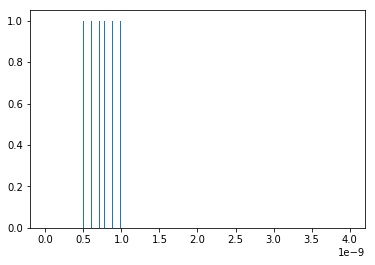

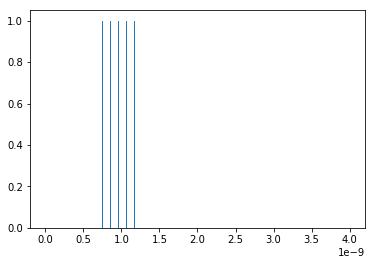

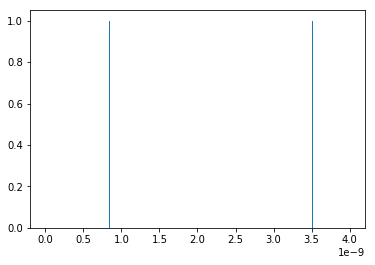

In [30]:

# window width 500p
# offset 250p
tdl_points_I = np.arange(0.5e-9,1e-9,35e-12)
Q_offset = 0.25e-9
#Q_offset = 0.35e-9
tdl_points_Q = np.arange(Q_offset+0.5e-9,Q_offset+1e-9,35e-12)

inter_sigma = 0e-12
tdl_points_intermediate = np.linspace(0,4e-9,10) + 4e-9/10
tdl_points_intermediate += inter_sigma*np.random.randn(len(tdl_points_intermediate))

tdl_hist_I = plt.hist(tdl_points_I,bins=t)
plt.show()
tdl_hist_Q = plt.hist(tdl_points_Q,bins=t)
plt.show()
tdl_hist_intermediate = plt.hist(tdl_points_intermediate,bins=t)
plt.show()

I_loc = np.append(tdl_hist_I[0],[0])
Q_loc = np.append(tdl_hist_Q[0],[0])
intermediate_loc = np.append(tdl_hist_intermediate[0],[0])

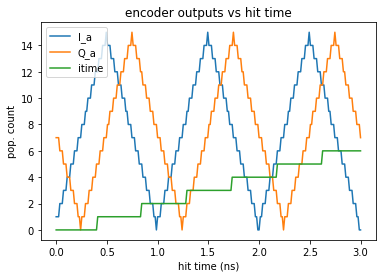

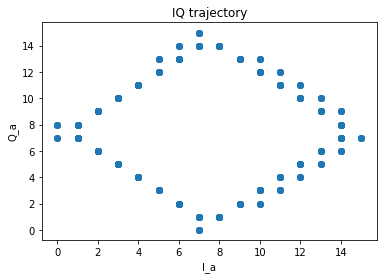

In [32]:
I = np.array([])
Q = np.array([])
itime = np.array([])

hit_time = np.linspace(0,3e-9,250)

for ht in hit_time:
    #osc = sqwave(2*np.pi*(t-ht)*osc_freq) >0
    osc = invrampwave(2*np.pi*(t-ht)*osc_freq) > asym_thr
    edge = t < ht
    I = np.append(I,[np.dot(I_loc,osc)])
    Q = np.append(Q,[np.dot(Q_loc,osc)])
    itime = np.append(itime,[np.dot(intermediate_loc,edge)])
    
#I -= np.sum(I_loc)/2
#Q -= np.sum(Q_loc)/2

plt.plot(hit_time*1e9,I    ,label="I_a")
plt.plot(hit_time*1e9,Q    ,label="Q_a")
plt.plot(hit_time*1e9,itime,label="itime")

plt.xlabel("hit time (ns)")
plt.ylabel("pop. count")
plt.title("encoder outputs vs hit time")
plt.legend()

plt.savefig("IQ_wfm.svg")
plt.show()

plt.scatter(I,Q)
plt.xlabel("I_a")
plt.ylabel("Q_a")
plt.title("IQ trajectory")
plt.savefig("IQ_plane.svg")
plt.show()

# center for the atan

I -= (np.max(I)+np.min(I))/2
Q -= (np.max(Q)+np.min(Q))/2
    


i = 0


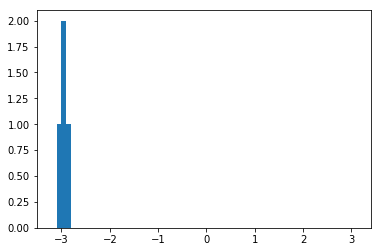

i = 1


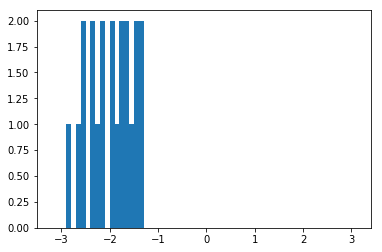

i = 2


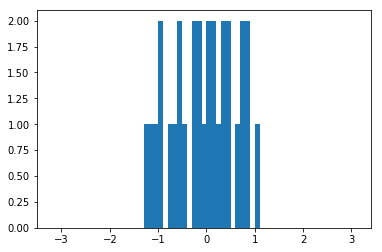

i = 3


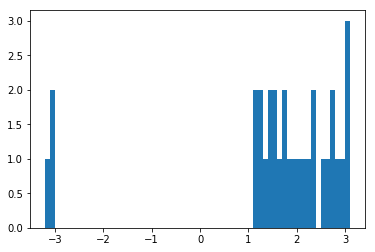

i = 4


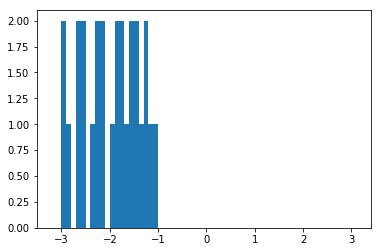

i = 5


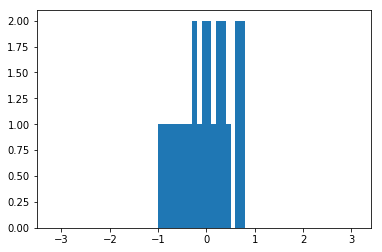

i = 6


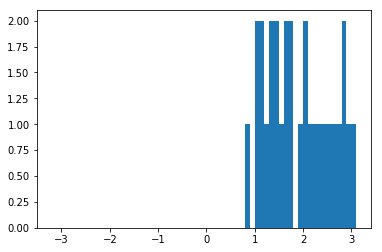

i = 7


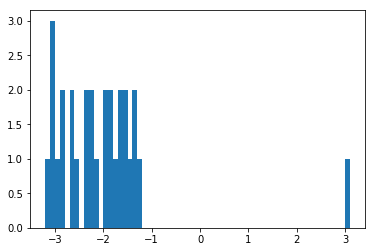

i = 8


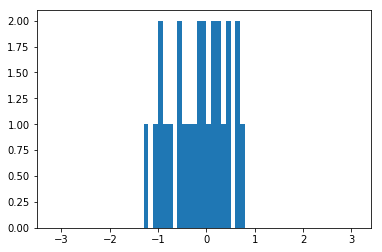

i = 9


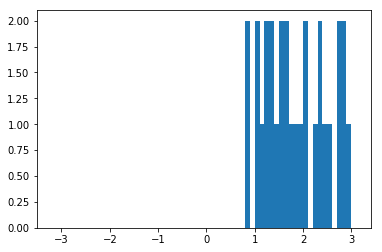

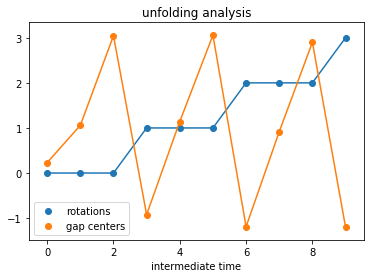

In [7]:
rotations, gap_centers = ana_rot(I,Q,itime,plot=True)

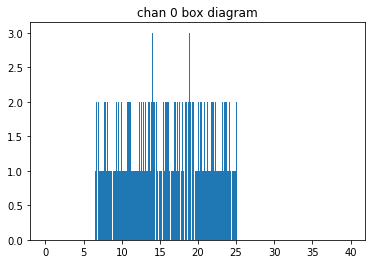

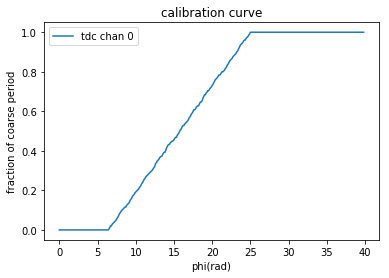

In [8]:
cphi = cont_phi_new(I,Q,itime,rotations,gap_centers)


phistep = 0.1

phirange = 40

hist_a = plt.hist(cphi,bins=np.arange(0,phirange,phistep))
plt.title("chan 0 box diagram")
plt.show()


calib_bins = hist_a[1][:-1]
plt.title("calibration curve")

curve_a = np.cumsum(hist_a[0])/np.sum(hist_a[0])

plt.plot(calib_bins,curve_a,label="tdc chan 0")
plt.legend()
plt.xlabel("phi(rad)")
plt.ylabel("fraction of coarse period")
plt.show()